# Aprendizaje no supervisado K-means 

In [1]:
import os
import path
import zipfile
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
Path = "/home/michell21/Datasets/"

In [3]:
#Se renombra el archivo para que sea más claro cuál es el que se usa. Vea el insiso e de la parte 3 de la práctica 0
with zipfile.ZipFile(Path+'OnlineRetail.csv.zip', 'r') as archive:
    archive.extractall(Path)

In [3]:
os.listdir(Path) #Se ha creado un nuevo archivo csv

['Datos_ruoa.zip',
 '100k-cars',
 'Titanic',
 'anime2020.zip',
 'OnlineRetail.csv.zip',
 'California_Houses.csv',
 'Pozos_Michoacan.xlsx',
 'OnlineRetail.csv',
 'California-housing.zip',
 '.ipynb_checkpoints',
 '100k-cars.zip',
 'Titanic.zip',
 'Anime2020']

In [3]:
o_retail = pd.DataFrame(pd.read_csv(Path+"OnlineRetail.csv"))

In [4]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [6]:
o_retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
#o_retail["CustomerID"] = o_retail["CustomerID"].fillna(0)

In [6]:
o_retail.info() #Revisar diferencia InvoiceNo y CustomerID

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


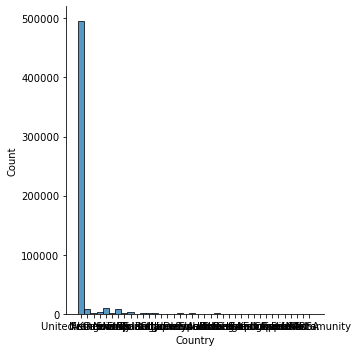

In [5]:
#print(o_retail["Country"].value_counts())
sns.displot(o_retail["Country"])

In [6]:
#o_retail.dropna(inplace=True)

In [9]:
#Vemos la cantidad de valores unicos que tiene cada columna
for i in o_retail:
    print(i, o_retail[i].nunique())

InvoiceNo 22190
StockCode 3684
Description 3896
Quantity 436
InvoiceDate 20460
UnitPrice 620
CustomerID 4372
Country 37


## Agregar pedidos por adelantado

Existen muchas compras hechas por adelantado, eso quiere decir que al consumidor se le DEBEN entregar n cantidad de articulos, por eso, en la columna Quantity hay valores negativos, los cuales hacen referencia a la cantidad de articulos que se deben. Para quitar eso, se agregará una nueva columna que nos diga si la comprá es adelantada o no

In [5]:
o_retail[o_retail["Quantity"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09-12-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09-12-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09-12-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09-12-2011 11:58,1.25,17315.0,United Kingdom


In [4]:
def status(df):
    #Seleccionamos los valores negativos en Quantity
    df["Status"] = 1 #"Bought"
    aux = df[df["Quantity"] < 0]
    for i in aux.index:
        df.loc[i, "Quantity"] = -1*(df.loc[i, "Quantity"])
        df.loc[i, "Status"] = 0 #"Credit"
    return df

In [5]:
status(o_retail)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,1
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France,1


In [10]:
o_retail[o_retail["Status"] == 0] #Crédito, Falta de stock

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
141,C536379,D,Discount,1,01-12-2010 09:41,27.50,14527.0,United Kingdom,0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,1,01-12-2010 09:49,4.65,15311.0,United Kingdom,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,12,01-12-2010 10:24,1.65,17548.0,United Kingdom,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,24,01-12-2010 10:24,0.29,17548.0,United Kingdom,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,24,01-12-2010 10:24,0.29,17548.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,11,09-12-2011 09:57,0.83,14397.0,United Kingdom,0
541541,C581499,M,Manual,1,09-12-2011 10:28,224.69,15498.0,United Kingdom,0
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,5,09-12-2011 11:57,10.95,15311.0,United Kingdom,0
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,1,09-12-2011 11:58,1.25,17315.0,United Kingdom,0


In [6]:
# Cambiar el dtype de CustomerID a str
o_retail['CustomerID'] = o_retail['CustomerID'].astype(str)

### Agregar una columna de monto total, multiplicando Quantity * UnitPrice

In [7]:
o_retail['AmountTotal'] = o_retail['Quantity']*o_retail['UnitPrice']

In [10]:
o_retail.describe()

,Quantity,UnitPrice,Status,AmountTotal
count,541909.000000,541909.000000,541909.000000,541909.000000
mean,11.340487,4.611114,0.980395,21.297622
std,217.995482,96.759853,0.138638,378.639158
min,1.000000,-11062.060000,0.000000,-11062.060000
25%,1.000000,1.250000,1.000000,3.750000
50%,3.000000,2.080000,1.000000,9.900000
75%,10.000000,4.130000,1.000000,17.700000
max,80995.000000,38970.000000,1.000000,168469.600000


## Cambiar el tipo de formato de la columna InvoiceDate a que sea date type

In [8]:
o_retail['InvoiceDate'] = pd.to_datetime(o_retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [12]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,AmountTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34


Crear una columna que muestre la última actividad de cada cliente, con respecto a la fecha más reciente del Dataset

In [12]:
date = o_retail['InvoiceDate'].max()
print(date)

2011-12-09 12:50:00


In [13]:
o_retail['LastInvoce'] = date - o_retail['InvoiceDate']

In [14]:
o_retail['LastInvoce'] = o_retail['LastInvoce'].dt.days

In [15]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,AmountTotal,LastInvoce
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373


## Crear un nuevo df con las columnas que usaremos. Este tendrá como index la columna CustomerID

In [15]:
inv = pd.DataFrame(o_retail.groupby('CustomerID')['InvoiceNo'].count())
amount = pd.DataFrame(o_retail.groupby('CustomerID')['AmountTotal'].sum())
last = pd.DataFrame(o_retail.groupby('CustomerID')['LastInvoce'].min())
#sta = pd.DataFrame(o_retail.groupby('CustomerID')['Status']).count()

In [21]:
inv.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [16]:
new_retail = pd.concat([inv, amount, last], axis=1)

In [18]:
new_retail.head()

,InvoiceNo,AmountTotal,LastInvoce
CustomerID,,,
0.0,135080,2.018623e+06,0
12346.0,2,1.543672e+05,325
12347.0,182,4.310000e+03,1
12348.0,31,1.797240e+03,74
12349.0,73,1.757550e+03,18


## Escalar los datos

In [17]:
scaler = MinMaxScaler() #StandardScaler
scalerSS = StandardScaler()

In [18]:
def escalar(df, scal):
    ind = df.index
    retail_scaler = pd.DataFrame(scal.fit_transform(df), index=ind)
    retail_scaler.columns = df.columns
    return retail_scaler

In [19]:
df_MMS = escalar(new_retail, scaler)
df_SS = escalar(new_retail, scalerSS)

In [24]:
df_MMS

,InvoiceNo,AmountTotal,LastInvoce
CustomerID,,,
0.0,1.000000,1.000000,0.000000
12346.0,0.000007,0.076472,0.871314
12347.0,0.001340,0.002135,0.002681
12348.0,0.000222,0.000890,0.198391
12349.0,0.000533,0.000871,0.048257
...,...,...,...
18280.0,0.000067,0.000089,0.742627
18281.0,0.000044,0.000040,0.482574
18282.0,0.000089,0.000089,0.018767


# Construir modelo

In [20]:
def prediccion(df, model):
    model.fit(df)
    print(model.predict(df))
    print("Inercia = ", model.inertia_)
    pred = model.predict(df)
    return pred

Las predicciones se manejarán usando 2 formatos de escala, MinMaxScaler y SatandarScaler y se analizarán las diferencias.

## Buscar el mejor número de clusters con inercia

In [21]:
def buscar_k(df):
    SSE = []
    for cluster in range(1,20):
        kmeans = KMeans(n_clusters = cluster, init='k-means++')
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)
    porc = 1
    for i in range(len(SSE)-1):
        dif = (SSE[i] - SSE[i+1])
        print('Punto',i+1,'a',i+2, dif/porc)
        porc = dif
        #print(dif, porc)
    plt.plot(range(1,20), SSE, 'o-')

### MinMaxSacaler

In [22]:
kmeansMMS = KMeans(n_clusters=2, init='k-means++')
predMMS = prediccion(df_MMS, kmeansMMS)

[1 0 0 ... 0 0 0]
Inercia =  67.6806854207515


In [23]:
#Modelo entrenado con Minmaxscaler
silhouette_MMS = silhouette_score(df_MMS, kmeansMMS.labels_, metric='euclidean')
print("Silhouette =", silhouette_MMS)

0.7383086323753945


In [24]:
predMMS[:350]

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Punto 1 a 2 253.50295639670952
Punto 2 a 3 0.1363588769784553
Punto 3 a 4 0.3870901859675165
Punto 4 a 5 0.502706476735322
Punto 5 a 6 0.49069287691289304
Punto 6 a 7 0.6068910795738045
Punto 7 a 8 0.9235484149803169
Punto 8 a 9 0.744713443976982
Punto 9 a 10 0.7583704513911387
Punto 10 a 11 0.6688252582536596
Punto 11 a 12 0.7274044196677418
Punto 12 a 13 0.6583638422756075
Punto 13 a 14 0.8735324967938539
Punto 14 a 15 0.6437959478056088
Punto 15 a 16 0.9530647105747421
Punto 16 a 17 0.7373198727729307
Punto 17 a 18 0.869682384856029
Punto 18 a 19 0.8229602992308461


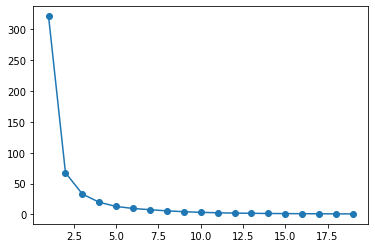

In [30]:
buscar_k(df_MMS) #Entre 4 y 5 es el k optimo

In [32]:
kmeansMMSK = KMeans(n_clusters = 5, init='k-means++')
predMMSK = prediccion(df_MMS, kmeansMMSK) #La inercia bajó

[0 4 0 ... 0 0 0]
Inercia =  12.998283407254766


In [57]:
predMMSK[:150]

array([2, 0, 3, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 3, 2, 0, 3, 0, 2, 0, 3, 0,
       3, 2, 0, 0, 2, 3, 3, 0, 0, 1, 0, 2, 0, 3, 0, 3, 3, 0, 0, 0, 3, 2,
       2, 3, 1, 0, 3, 0, 3, 2, 3, 3, 1, 0, 0, 3, 3, 0, 3, 0, 1, 3, 1, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0, 1, 0, 0,
       3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 3, 0, 0, 2, 3, 2, 0, 2, 1, 3, 0, 2,
       1, 3, 3, 2, 2, 3, 0, 0, 3, 3, 1, 0, 0, 0, 0, 3, 0, 3], dtype=int32)

### StandardScaler

In [24]:
kmeansSS = KMeans(n_clusters=2, init='k-means++')
predSS = prediccion(df_SS, kmeansSS)

[0 0 0 ... 0 0 1]
Inercia =  4891.799479100922


In [26]:
#Modelo entrenado con StandardScaler
silhouette_SS = silhouette_score(df_MMS, kmeansSS.labels_, metric='euclidean')
print("Silhouette =", silhouette_SS)

Silhouette = 0.8113704009700877


In [27]:
predSS[:350]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Punto 1 a 2 8227.200520899114
Punto 2 a 3 0.42273016841899774
Punto 3 a 4 0.1366915390870341
Punto 4 a 5 0.6599224535685444
Punto 5 a 6 0.5910019150331535
Punto 6 a 7 0.5004578590657681
Punto 7 a 8 0.8427047562118207
Punto 8 a 9 0.5803274441636229
Punto 9 a 10 0.5394597338721148
Punto 10 a 11 0.8602875461136832
Punto 11 a 12 1.0646311208570927
Punto 12 a 13 0.7981447488301132
Punto 13 a 14 0.869304321226092
Punto 14 a 15 0.9215056176147315
Punto 15 a 16 0.5309031563692295
Punto 16 a 17 1.263309525637219
Punto 17 a 18 0.9194594463960396
Punto 18 a 19 0.7141956490575219


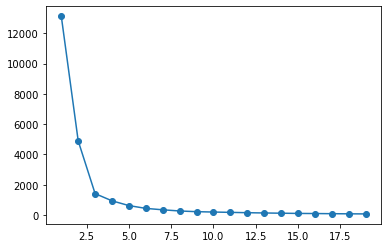

In [31]:
buscar_k(df_SS) # Entre 8 y 9 es el k optimo

In [33]:
kmeansSSK = KMeans(n_clusters = 8, init='k-means++')
predSSK = prediccion(df_SS, kmeansSSK)#La inercia bajó

[1 7 0 ... 0 0 3]
Inercia =  268.48616907818297


In [59]:
predSSK.

array([6, 0, 0, 0, 1, 0, 5, 1, 5, 0, 0, 0, 4, 0, 1, 4, 5, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 5, 0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1,
       1, 0, 5, 0, 0, 0, 0, 1, 0, 0, 5, 6, 0, 5, 0, 0, 5, 0, 5, 0, 5, 0,
       4, 0, 0, 4, 0, 4, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 5, 4, 0,
       5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 4, 4, 0, 4, 0, 4, 4, 0, 0, 0,
       0, 0, 4, 0, 1, 4, 0, 0, 5, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 5, 0, 1,
       5, 0, 0, 1, 1, 0, 4, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

En ambos casos, la inercia se redujo considerablemente

## Graficar los resultados

In [58]:
#InvoiceNo	AmountTotal	LastInvoce
def resutados(df, pred):
    df_result = df.copy()
    df_result['cluster'] = pred
    at = df_result[df_result["AmountTotal"] < 75000]
    k = at['cluster'].nunique()
    fig, axes = plt.subplots(3, 1,figsize=(16,12))
    axes[0].set_title("AmountTotal vs LastInvoce")
    axes[1].set_title("AmountTotal vs InvoiceNo")
    axes[2].set_title("LastInvoce vs InvoiceNo")

    sns.scatterplot(at["AmountTotal"], at["LastInvoce"], hue = at["cluster"], 
                    palette = sns.color_palette('hls',k), ax=axes[0])
    sns.scatterplot(at["AmountTotal"], at["InvoiceNo"], hue = at["cluster"], 
                    palette = sns.color_palette('hls',k), ax=axes[1])
    sns.scatterplot(at["LastInvoce"], at["InvoiceNo"], hue = at["cluster"], 
                    palette = sns.color_palette('hls',k), ax=axes[2])

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

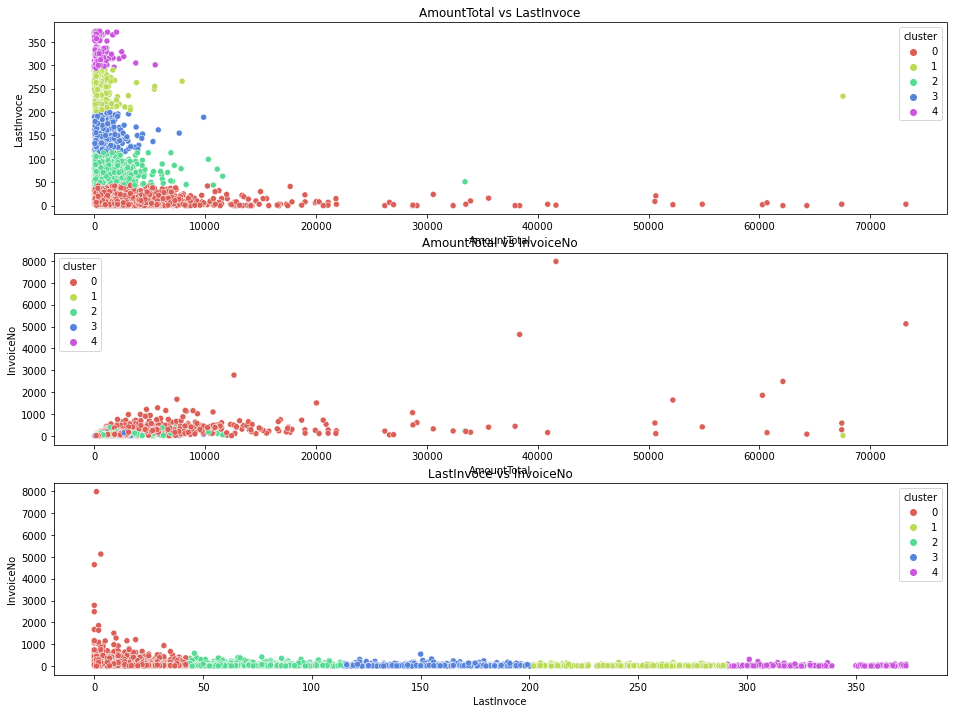

In [59]:
resutados(new_retail, predMMSK)

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

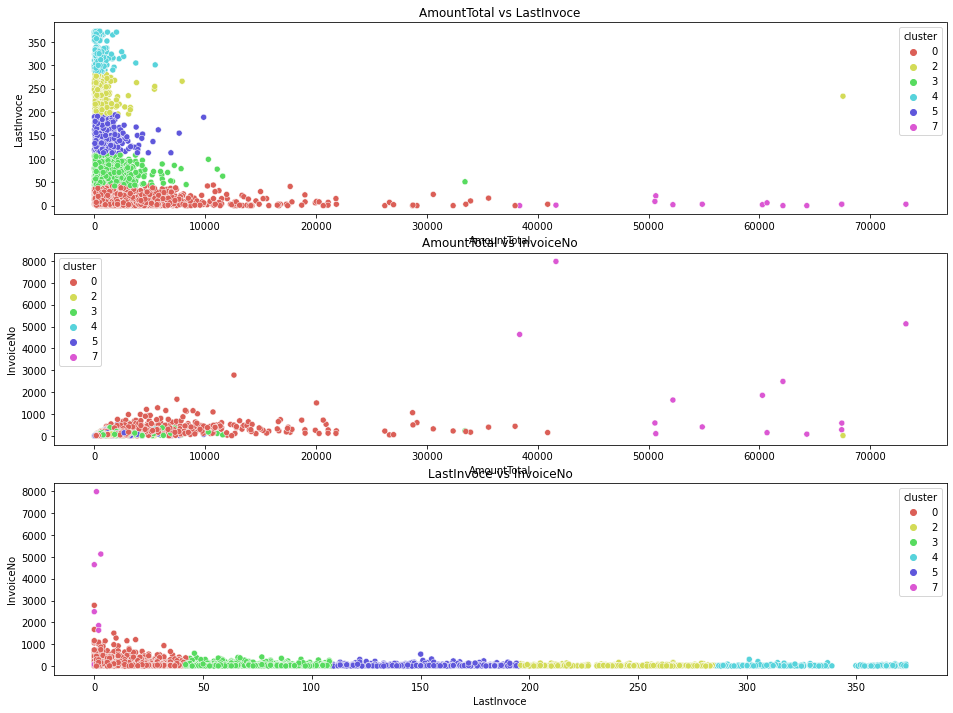

In [60]:
resutados(new_retail, predSSK)

## Método Silhouette

El valor de la puntuación de Silhouette varía de -1 a 1. Si la puntuación es 1, el grupo es denso y está bien separado que otros grupos. Un valor cercano a 0 representa grupos superpuestos con muestras muy cercanas al límite de decisión de los grupos vecinos. Una puntuación negativa (-1,0) indica que las muestras pueden haber sido asignadas a grupos incorrectos.

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

In [35]:
#Modelo entrenado con Minmaxscaler
silhouette_MMSk = silhouette_score(df_MMS, kmeansMMSK.labels_, metric='euclidean')
print(silhouette_MMSk)

0.6143242841711527


In [36]:
#Modelo entrenado con Standardscaler
silhouette_SSK = silhouette_score(df_SS, kmeansSSK.labels_, metric='euclidean')
print(silhouette_SSK)

0.5537561343887281


## revisar t-SNE para las gráficas

In [93]:
def graf_tSNE(data, pred):
    tsne = TSNE(n_components = 3, random_state = 0)
    X = pd.DataFrame(tsne.fit_transform(data))
    X.columns = data.columns
    labels = pd.DataFrame(pred)
    k = labels[0].nunique()
    sns.scatterplot(X["AmountTotal"], X["LastInvoce"], X["InvoiceNo"], hue = labels[0])#palette = sns.color_palette('hls',k))

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


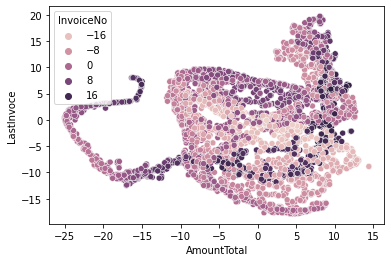

In [94]:
graf_tSNE(new_retail, predMMSK)

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


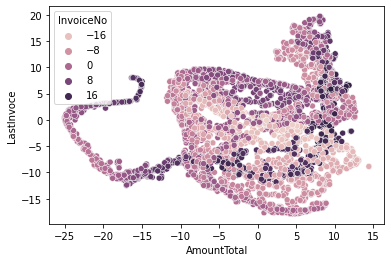

In [95]:
graf_tSNE(new_retail, predSSK)